<a href="https://colab.research.google.com/github/mofuoku417/anomaly-detection/blob/main/Detecting_Anomalies_In_Crude_Oil_Prices_Using_Deep_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

###**Problem statement**

This project aims to analyze crude palm oil data from 01/04/200 - 6/17/22 using anomaly detection techniques to uncover hidden patterns and outliers in the data. We will use the keras/TensorFlow library in Python to construct and train a model to detect anomalous data points within the dataset. Finally, we will analyze and interpret our results to draw meaningful conclusions about the Crude oil market.

####Loading the required libraries

In [15]:
import numpy as np
from pandas import read_csv
import plotly.express as px
import plotly.graph_objects as go
import math 
from keras.models import Sequential
from keras.layers import LSTM, Input, Dropout
from keras.layers import Dense
from keras.layers import RepeatVector
from keras.layers import TimeDistributed
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from keras.models import Model
import seaborn as sns
import matplotlib.dates as mdates # Date formatting
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

####Loading the dataset

In [101]:
#Load dataset
path = 'https://raw.githubusercontent.com/mofuoku417/anomaly-detection/main/Data/crude_oil.csv'
dataframe = read_csv(path, parse_dates=True,)

###Data Preprocessing

In [102]:
print(f"Downloaded {len(dataframe)} rows of data.")
dataframe

Downloaded 23024 rows of data.


,Symbol,Date,Open,High,Low,Close,Volume,Currency
0,Brent Oil,1/4/00,23.9000,24.7000,23.8900,24.3900,32509,USD
1,Brent Oil,1/5/00,24.2500,24.3700,23.7000,23.7300,30310,USD
2,Brent Oil,1/6/00,23.5500,24.2200,23.3500,23.6200,44662,USD
3,Brent Oil,1/7/00,23.5700,23.9800,23.0500,23.0900,34826,USD
4,Brent Oil,1/10/00,23.0400,23.7800,23.0400,23.7300,26388,USD
...,...,...,...,...,...,...,...,...
23019,Heating Oil,6/13/22,4.3612,4.3762,4.1949,4.2834,46406,USD
23020,Heating Oil,6/14/22,4.2749,4.4570,4.2488,4.3940,36652,USD
23021,Heating Oil,6/15/22,4.3816,4.6070,4.3557,4.5470,36908,USD
23022,Heating Oil,6/16/22,4.5320,4.5825,4.4124,4.5713,28269,USD


In [103]:
#Checking for missing values
dataframe.isnull().sum()

Symbol      0
Date        0
Open        0
High        0
Low         0
Close       0
Volume      0
Currency    0
dtype: int64

There are no missing values

In [104]:
#Checking the data types
dataframe.dtypes

Symbol       object
Date         object
Open        float64
High        float64
Low         float64
Close       float64
Volume        int64
Currency     object
dtype: object

In [105]:
#Selecting only symbol for Brent Oil
df = dataframe[dataframe['Symbol']=='Brent Oil']

In [106]:
# Selecting columns of interest
df = df[['Date', 'Close']]

####Changing the ‘Date Starting’ column to a date datatype:

In [107]:
df['Date'] = pd.to_datetime(df['Date'])

In [108]:
from plotly.subplots import make_subplots
import plotly.graph_objects as go
from plotly.graph_objs import Line

fig = make_subplots(rows=1, cols=1,subplot_titles=('Close'))

fig.add_trace(
    Line(x=df.index, y=df.Close),
    row=1, col=1
)

fig.add_trace(
    go.Line(x=df.index, y=df.Close),
    row=1, col=1
)

fig.update_layout(height=600, width=1000, title_text="Line Plots")

fig.show()

In [100]:
#sns.lineplot(x=df['Date'], y=df['Close'])

In [76]:
print("The starting date is: ", df['Date'].min())
print("The ending date is: ", df['Date'].max())

The starting date is:  2000-01-04 00:00:00
The ending date is:  2022-06-17 00:00:00


In [109]:
#I used train data from Mid 1/04/00 to 01/04/2016
train, test = df.loc[df['Date'] <= '2016-04-01'], df.loc[df['Date'] > '2016-04-01']

In [111]:
# Because LSTM employs sigmoid and tanh functions that are sensitive to magnitude, data must be adjusted.
# the dataset should be normalized
scaler = MinMaxScaler() 
#scaler = StandardScaler()
scaler = scaler.fit(train[['Close']])

In [112]:
train['Close'] = scaler.transform(train[['Close']])
test['Close'] = scaler.transform(test[['Close']])

<ipython-input-112-c7bfe784ac5d>:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-112-c7bfe784ac5d>:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [114]:
seq_size = 30  # The number of time steps taken to look back 
def to_sequences(x, y, seq_size=1):
    x_values = []
    y_values = []

    for i in range(len(x)-seq_size):
        #print(i)
        x_values.append(x.iloc[i:(i+seq_size)].values)
        y_values.append(y.iloc[i+seq_size])
        
    return np.array(x_values), np.array(y_values)

trainX, trainY = to_sequences(train[['Close']], train['Close'], seq_size)
testX, testY = to_sequences(test[['Close']], test['Close'], seq_size)

In [115]:
trainX, trainY = to_sequences(train[['Close']], train['Close'], seq_size)
testX, testY = to_sequences(test[['Close']], test['Close'], seq_size)

In [116]:
# define Autoencoder model
#Input shape would be seq_size, 1 - 1 beacuse we have 1 feature. 
# seq_size = trainX.shape[1]

model = Sequential()
model.add(LSTM(128, input_shape=(trainX.shape[1], trainX.shape[2])))
model.add(Dropout(rate=0.2))

In [117]:
model.add(RepeatVector(trainX.shape[1]))

In [118]:
model.add(LSTM(128, return_sequences=True))
model.add(Dropout(rate=0.2))
model.add(TimeDistributed(Dense(trainX.shape[2])))
model.compile(optimizer='adam', loss='mae')
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_4 (LSTM)               (None, 128)               66560     
                                                                 
 dropout_4 (Dropout)         (None, 128)               0         
                                                                 
 repeat_vector_2 (RepeatVect  (None, 30, 128)          0         
 or)                                                             
                                                                 
 lstm_5 (LSTM)               (None, 30, 128)           131584    
                                                                 
 dropout_5 (Dropout)         (None, 30, 128)           0         
                                                                 
 time_distributed_2 (TimeDis  (None, 30, 1)            129       
 tributed)                                            

Epoch 1/10
117/117 [==============================] - 12s 78ms/step - loss: 0.2402 - val_loss: 0.1148
Epoch 2/10
117/117 [==============================] - 8s 65ms/step - loss: 0.2337 - val_loss: 0.1031
Epoch 3/10
117/117 [==============================] - 8s 73ms/step - loss: 0.2328 - val_loss: 0.1150
Epoch 4/10
117/117 [==============================] - 8s 73ms/step - loss: 0.2332 - val_loss: 0.1151
Epoch 5/10
117/117 [==============================] - 8s 70ms/step - loss: 0.2319 - val_loss: 0.1107
Epoch 6/10
117/117 [==============================] - 8s 67ms/step - loss: 0.2311 - val_loss: 0.1564
Epoch 7/10
117/117 [==============================] - 8s 71ms/step - loss: 0.2317 - val_loss: 0.1210
Epoch 8/10
117/117 [==============================] - 8s 72ms/step - loss: 0.2312 - val_loss: 0.1107
Epoch 9/10
117/117 [==============================] - 8s 66ms/step - loss: 0.2314 - val_loss: 0.1276
Epoch 10/10
117/117 [==============================] - 8s 72ms/step - loss: 0.2310 - val_l

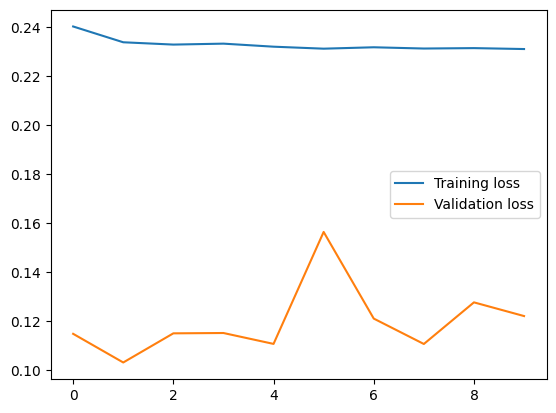

In [119]:
# fit model
history = model.fit(trainX, trainY, epochs=10, batch_size=32, validation_split=0.1, verbose=1)

plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.legend()

130/130 [==============================] - 3s 22ms/step


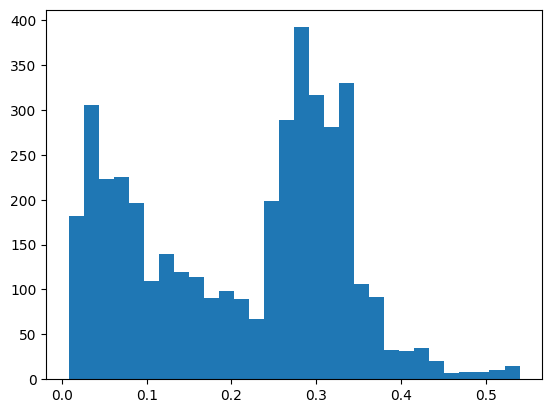

In [120]:
# Anomaly is defined as a substantial reconstruction error.  
# This value above which we label anomalous can be defined. 
# Consider MAE in training prediction.

trainPredict = model.predict(trainX)
trainMAE = np.mean(np.abs(trainPredict - trainX), axis=1)
plt.hist(trainMAE, bins=30)
max_trainMAE = 0.3  

50/50 [==============================] - 1s 17ms/step


(array([210., 128., 133., 106.,  84., 128., 112.,  77.,  89., 104.,  90.,
         36.,  47.,  62.,  21.,  12.,   9.,   7.,   7.,   5.,   7.,  12.,
         18.,  11.,   6.,  13.,  23.,  12.,   3.,   4.]),
 array([0.00777718, 0.01975006, 0.03172293, 0.04369581, 0.05566868,
        0.06764156, 0.07961444, 0.09158731, 0.10356019, 0.11553306,
        0.12750594, 0.13947881, 0.15145169, 0.16342457, 0.17539744,
        0.18737032, 0.19934319, 0.21131607, 0.22328894, 0.23526182,
        0.2472347 , 0.25920757, 0.27118045, 0.28315332, 0.2951262 ,
        0.30709908, 0.31907195, 0.33104483, 0.3430177 , 0.35499058,
        0.36696345]),
 <BarContainer object of 30 artists>)

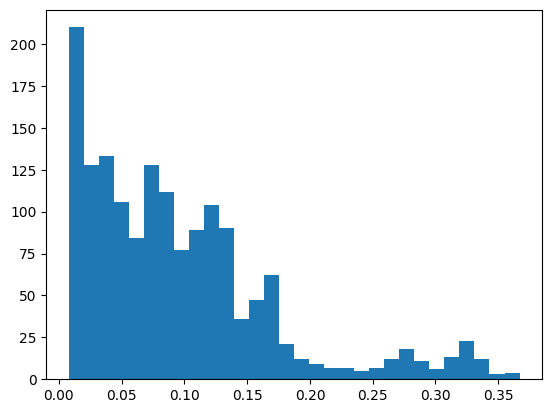

In [121]:
testPredict = model.predict(testX)
testMAE = np.mean(np.abs(testPredict - testX), axis=1)
plt.hist(testMAE, bins=30)

In [122]:
# Capture all relevant information in a DataFrame for simple visualization
anomaly_df = pd.DataFrame(test[seq_size:])
anomaly_df['testMAE'] = testMAE
anomaly_df['max_trainMAE'] = max_trainMAE
anomaly_df['anomaly'] = anomaly_df['testMAE'] > anomaly_df['max_trainMAE']
anomaly_df['Close'] = test[seq_size:]['Close']

<Axes: xlabel='Date', ylabel='testMAE'>

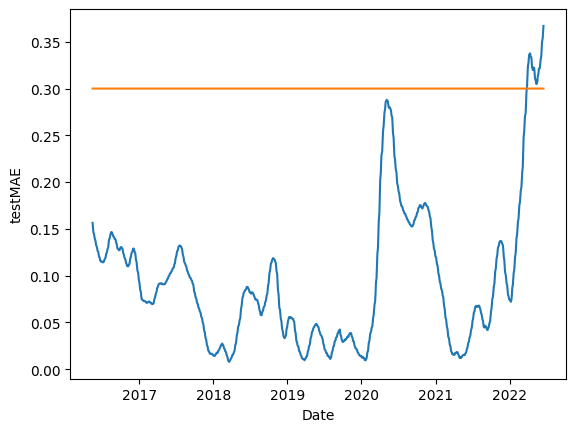

In [123]:
# Now ploting testMAE vs max_trainMAE
sns.lineplot(x=anomaly_df['Date'], y=anomaly_df['testMAE'])
sns.lineplot(x=anomaly_df['Date'], y=anomaly_df['max_trainMAE'])

In [127]:
anomalies = anomaly_df.loc[anomaly_df['anomaly'] == True]

In [134]:
anomalies.head(5)

,Date,Close,testMAE,max_trainMAE,anomaly
5708,2022-03-28,0.738318,0.302694,0.3,True
5709,2022-03-29,0.720794,0.308227,0.3,True
5710,2022-03-30,0.745872,0.313744,0.3,True
5711,2022-03-31,0.702726,0.318511,0.3,True
5712,2022-04-01,0.675312,0.323413,0.3,True


In [126]:
#Ploting the anomalies
sns.lineplot(x=anomaly_df['Date'], y=scaler.inverse_transform(anomaly_df['Close']))
sns.scatterplot(x=anomalies['Date'], y=scaler.inverse_transform(anomalies['Close']), color='r')

ValueError: ignored

In [40]:
#df1['Date'] = pd.to_datetime(df1['Date'])
#df1.info()
#df1 = pd.DataFrame(df1)
#df1['Date'] = df1['Date'].apply(pd.to_datetime)
#df1.set_index('Date',inplace=True)

In [ ]:
# Work in progress